## =Regression Model=

# Imports

In [2]:
import numpy as np
import math

import itertools

import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
path = 'datasets/coins project/neo_full.csv'
data = pd.read_csv(path)
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  
0                 0                0                 19  
1                 0                0                 19  
2                 0                0                 19  
3                 0                0                 20  
4                 0                0                 20

# Preprocessing

In [4]:
zero_cleaner_features =['twitterFollowers','redditSubscribers','forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues','pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
features =['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
        'alexaRank', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']

def zero_cleaner(column):
    up =0
    for i in range(len(column)):
        val = column[i]
        if column[i] == 0 and up ==0 and i >=1:
            up = column[i-1]
        if column[i] != 0 and up!=0:
            j=i
            ave = (column[i]+up)/2
            while j>=1 and column[j-1] ==0:
                column[j-1] = ave
                j-=1
            up = 0

def target_generator(data):
    b = data['price']
    in_days = 1
    target = 'price_in_{}_day'.format(in_days)
    data[target] = data['price']
    a = data[target]
    for i in range(len(b)):
        if i<len(b)-in_days:
            a[i] = b[i+in_days]
        else:
            a[i] = b[i-5:i].mean()
               
def cleaner(data):
    for feature in zero_cleaner_features:
        zero_cleaner(data[feature])
    target_generator(data) 

In [5]:
cleaner(data)               
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  price_in_1_day  
0                 0                0                 19       30.957925  
1                 0                0                 19       23.023138  
2                 0                0                 19       23.674946  
3                 0                0                 20       21.515456  
4                 0                0                 20       30.842616

# Train

In [6]:
data

name                   date      price     volume   marketCap  \
0     neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1     neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2     neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3     neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4     neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   
...   ...                    ...        ...        ...         ...   
1052  neo  2020-07-20 00:00:00.0  10.641138  147802809   750519473   
1053  neo  2020-07-21 00:00:00.0  10.401539  139362127   734073815   
1054  neo  2020-07-22 00:00:00.0  11.172521  247577766   787658281   
1055  neo  2020-07-23 00:00:00.0  11.573522  222309605   818798717   
1056  neo  2020-07-24 00:00:00.0  11.427525  225882227   805812992   

      twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0                65687                      3                       136   
1                66436                      3                       123   
2                67419                      3                       127   
3                68640                      3                       171   
4                70173                      2                       165   
...                ...                    ...                       ...   
1052            319958                      0                         7   
1053            319907                      0                         9   
1054            319940                      1                        10   
1055            320004                      1                         7   
1056            319983                      1                         9   

      redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0                 22013                      703                        0   
1                 22277                      580                        0   
2                 22821                      963                        0   
3                 23713                     1309                        0   
4                 24351                     1097                        0   
...                 ...                      ...                      ...   
1052              99806                     1510                        0   
1053              99820                     1635                        0   
1054              99832                     2135                        0   
1055              99836                     1989                        0   
1056              99846                     1755                        0   

      alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0         39974            0    279    799          208           39   
1         39580            0    281    805          209           39   
2         39065            0    281    809          209           39   
3         38513            0    282    812          209           39   
4         37837            0    284    816          210           40   
...         ...          ...    ...    ...          ...          ...   
1052     192818            0    906   2991          368          758   
1053     192818            0    905   2992          368          760   
1054     192818            0    905   2993          368          760   
1055     192818            0    906   2995          369          761   
1056     192818            0    906   2997          369          762   

      closedIssues  pullRequestsMerged  pullRequestContributors  \
0               32                   0                       10   
1               32                   0                       10   
2               32                   0                       10   
3               32                   0                       10   
4               33                   0                       10   
...            ...                 ...                      ...   
1052

In [7]:
features = ['price', 'volume', 'marketCap', 'twitterFollowers',
            'redditAveragePosts48h', 'redditAverageComments48h',
            'redditSubscribers', 'redditAccountsActive48h',
            'alexaRank', 'forks', 'stars',
            'subscribers', 'totalIssues', 'closedIssues',
            'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
            'commitCount4Weeks']
targets = ['price_in_1_day']

def fit_and_predict(data, **params):
    
    if len(params)>0:
        params = params['params']['params']
        n_estimators = params[0]  
        max_depth = params[1]  
        learning_rate = params[2]  
        min_child_weight = params[3]  
        subsample = params[4] 
        colsample_bytree = params[5]
        colsample_bylevel = params[6]
        gamma = params[7] 
    else:   
        n_estimators = 100  # Number of boosted trees to fit. default = 100
        max_depth = 3  # Maximum tree depth for base learners. default = 3
        learning_rate = 0.1  # Boosting learning rate (xgb’s “eta”). default = 0.1
        min_child_weight = 1  # Minimum sum of instance weight(hessian) needed in a child. default = 1
        subsample = 1  # Subsample ratio of the training instance. default = 1
        colsample_bytree = 1  # Subsample ratio of columns when constructing each tree. default = 1
        colsample_bylevel = 1  # Subsample ratio of columns for each split, in each level. default = 1
        gamma = 0  # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

    
    
    model_seed = 100
    
    ###################################################################################
    ###################################################################################
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[features +targets])
    # Convert the numpy array back into pandas dataframe
    data_scaled = pd.DataFrame(data_scaled, columns=features +targets)
    X_train = data_scaled[:-1][features]
    price_index = X_train.columns.get_loc('price')
    y_train = data_scaled[:-1][targets]
    X_test = (data_scaled.tail(1))[:][features]
    ###################################################################################
    ###################################################################################

    model = XGBRegressor(seed=model_seed,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            gamma=gamma)

    # Train the regressor
    model.fit(X_train, y_train)
    est_scaled = model.predict(X_test)
    scaled_today_price = X_test.iloc[-1, price_index]
    scaled_tomorrow_price = est_scaled[0]
    tomorrow_percentage = ((scaled_tomorrow_price - scaled_today_price) / abs(scaled_today_price)) * 100
    today_price = data.iloc[-1]['price']
    return {'today_price': today_price, 'tomorrow_price': today_price + (today_price*(tomorrow_percentage/100)), 'tomorrow_percentage': tomorrow_percentage}


In [8]:
fit_and_predict(data)

{'today_price': 11.427525396480426,
 'tomorrow_price': 11.329823148565422,
 'tomorrow_percentage': -0.8549729230537925}

# Simulation & Predict

In [9]:
simulation_size = 60
data_size = data.shape[0]
print('data size:{} = train size:{} + test size:{}'.format(data_size, data_size-simulation_size, simulation_size ))
true_values = data[data_size-simulation_size:]['price'].values

def simulation(**params):
    predict_values = []
    for i in range(simulation_size,0,-1):
        today_data = data[:data_size-i]
    
        if len(params):
            tomorrow_predict = fit_and_predict(today_data, params = params)
        else:
            tomorrow_predict = fit_and_predict(today_data)
            
        predict_values.append(tomorrow_predict['tomorrow_price'])
    return predict_values

data size:1057 = train size:997 + test size:60


In [10]:
predict_values = simulation()

# Evaluation

In [11]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    return math.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

def get_bank(y_true, y_pred):
    bank = 100
    coin = 0
    for i, elm in enumerate(y_pred):
        if i == len(y_pred)-1:
            continue
        diff = y_pred[i+1]-y_pred[i]
        true_diff = y_true[i+1]-y_true[i]
        if diff < 0 and coin != 0:
            bank+=coin - y_true[i]
            coin = 0
        if diff>0 and coin==0:
            coin = y_true[i]

    return (bank-100) / 100

def plot_trend(true_trend,pred_trend = [], split_point=0, full_x=False, title=''):
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(true_trend,'blue',label = "true values",alpha=0.6)
    if len(pred_trend) >0:
        plt.plot(pred_trend,'red',label ='prediction',alpha=0.6)
    plt.legend(loc="upper left")
    plt.title(title)
    if full_x ==True:
        plt.xticks(range(len(true_trend)))
        plt.grid(True)
    if split_point !=0:
        plt.axvline(x=split_point,linewidth=2.5)
    plt.show()
    
def full_result(true_values,predict_values):
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    bank = get_bank(true_values,predict_values)
    title ='result of {} days of simulation \n\nrmse: {}\nmape: {} \nbank: {} '.format(simulation_size,rmse,mape,bank)
    plot_trend(true_values,predict_values, title = title)

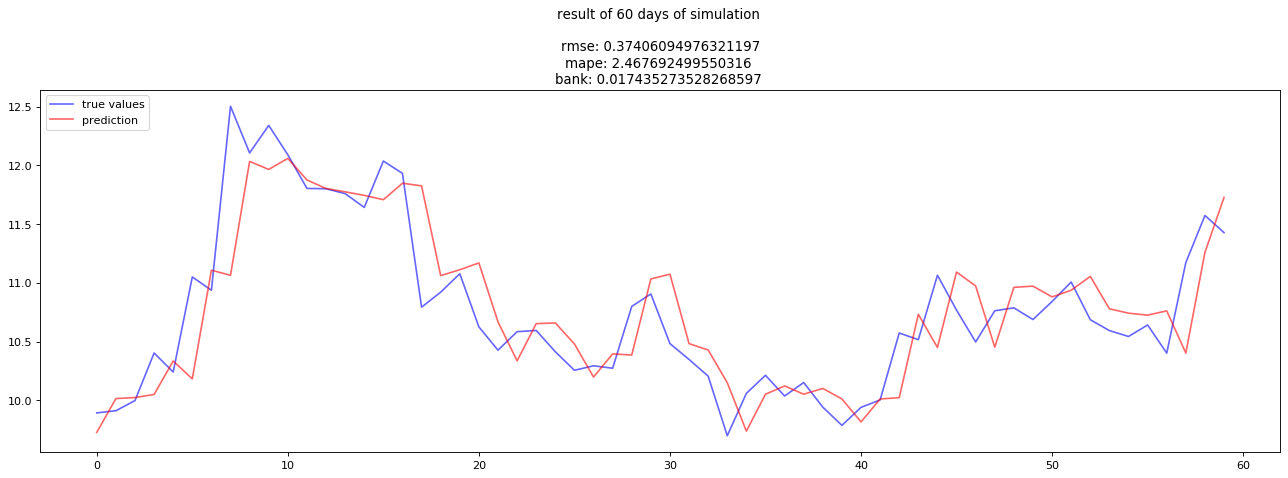

In [12]:
full_result(true_values,predict_values)

# Tune

In [1]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]  
max_depth = [int(x) for x in np.linspace(start = 3, stop = 100, num = 5)]   
learning_rate = [0.005, 0.05, 0.1 , 0.5 ,0.8]  
min_child_weight = [int(x) for x in np.linspace(start = 1, stop = 100, num = 5)]  
subsample = [0.2, 0.5, 1] 
colsample_bytree = [0.2, 0.5, 1]
colsample_bylevel = [0.2, 0.5, 1]
gamma = [int(x) for x in np.linspace(start = 0, stop = 20, num = 5)] 

# n_estimators = [100]  # Number of boosted trees to fit. default = 100
# max_depth = [3]  # Maximum tree depth for base learners. default = 3
# learning_rate = [0.1]  # Boosting learning rate (xgb’s “eta”). default = 0.1
# min_child_weight = [1]  # Minimum sum of instance weight(hessian) needed in a child. default = 1
# subsample = [1]  # Subsample ratio of the training instance. default = 1
# colsample_bytree = [1]  # Subsample ratio of columns when constructing each tree. default = 1
# colsample_bylevel = [1]  # Subsample ratio of columns for each split, in each level. default = 1
# gamma = 0


all_features_list = [n_estimators,max_depth,learning_rate,min_child_weight,subsample,colsample_bytree,colsample_bylevel,gamma]

comb = list(itertools.product(*all_features_list))
print(len(comb))
rmse_result = []
mape_result = []
min_i_rmse = 0
min_val_rmse = 10000
min_i_mape = 0
min_val_mape = 10000

counter = 0
comb_size = len(comb)
for i in comb: 
    counter+=1
    if counter % 100 ==0:
        print('{}%'.format(counter/comb_size*100))
    
    predict_values = simulation(params = i)
    
    rmse = get_rmse(true_values,predict_values)
    mape = get_mape(true_values,predict_values)
    if min_val_mape > mape:
        min_val_mape = mape
        min_i_mape = i
    if min_val_rmse > rmse:
        min_val_rmse = rmse
        min_i_rmse = i
        
    rmse_result.append(rmse)
    mape_result.append(mape)
print('best result with rmse is :\t{}\nbest result with mape is :\t{}'.format(min_i_rmse, min_i_mape))
plot_trend(rmse_result, split_point =comb.index(min_i_rmse) ,title = 'rmse result : {}'.format(min_val_rmse) ,full_x=True)
plot_trend(mape_result, split_point =comb.index(min_i_mape) ,title = 'mape result : {}'.format(min_val_mape) ,full_x=True)

NameError: name 'np' is not defined

tune base on rmse


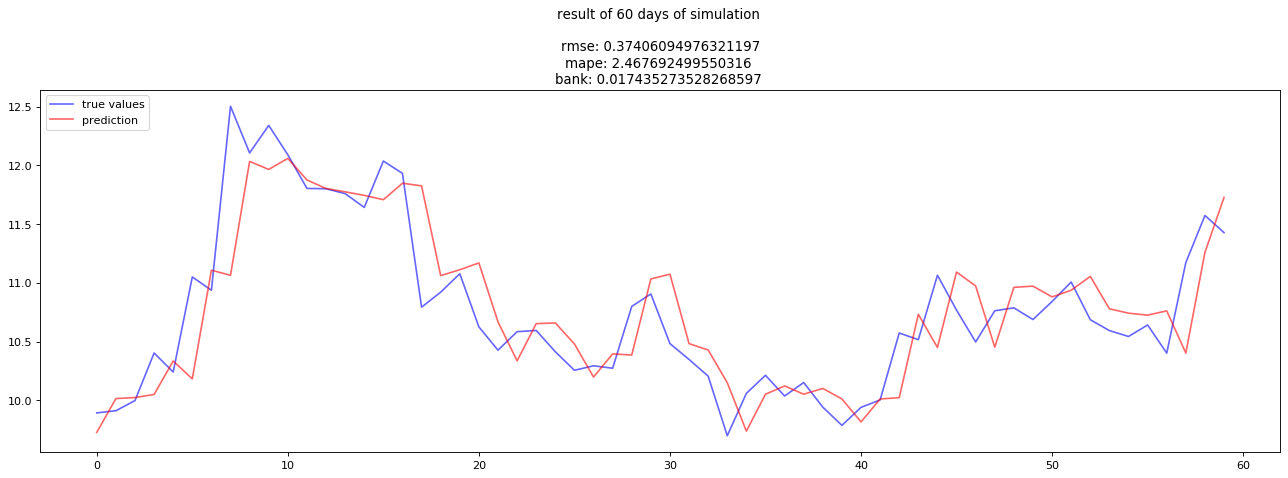

tune base on mape


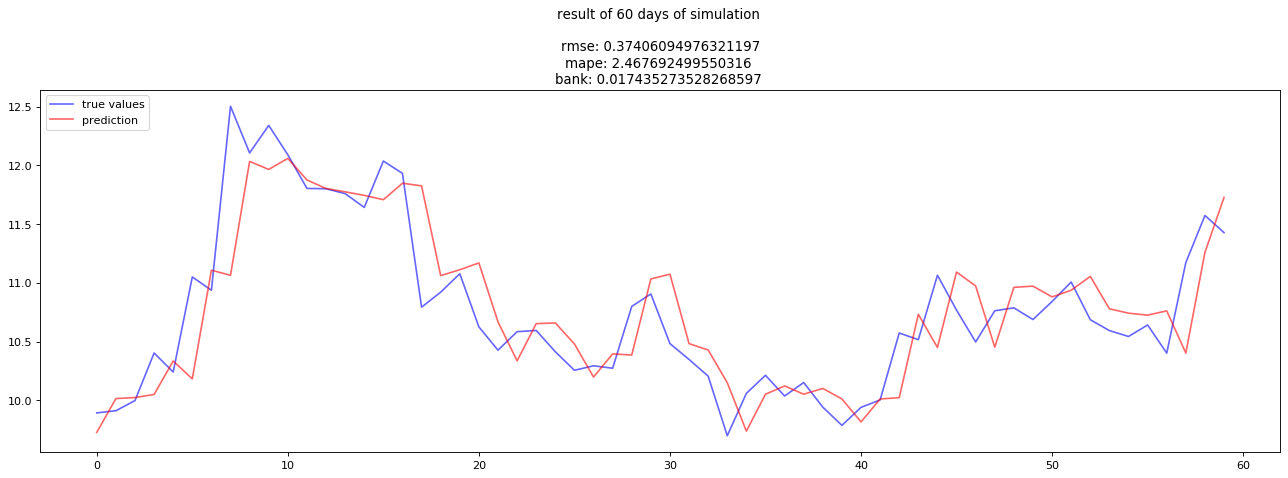

In [18]:
print('tune base on rmse')
predict_values = simulation(params = min_i_rmse)
full_result(true_values,predict_values)

print('tune base on mape')
predict_values = simulation(params = min_i_mape)
full_result(true_values,predict_values)